In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import GenerationDiscreteObs as FSC_DiscreteObs
from FSC import InferenceDiscreteObs as FSC_InferenceDiscreteObs
import ObsModels 

In [46]:
# set matplotlib font to avenir
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Avenir'

# Finite State Controller with $M = 2$, $A = 2$, $Y = 2$

# Observations

In [364]:
NStepsObs = 100
NTraj = 200
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(200, 100)

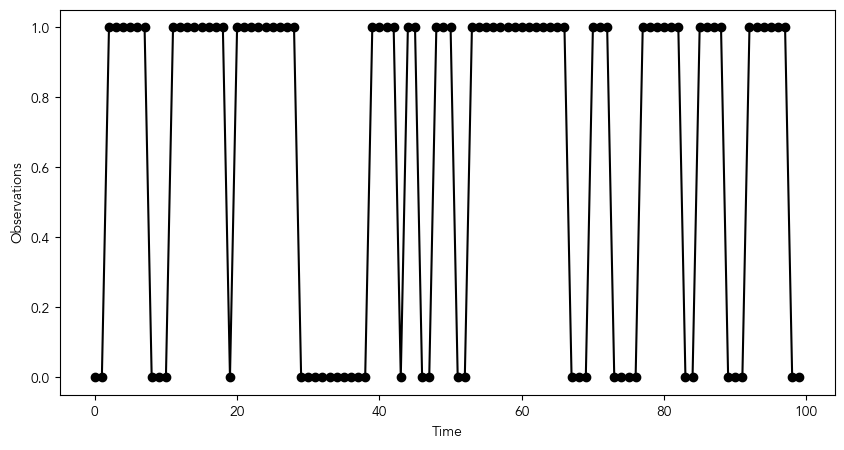

In [365]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

## Structured transition matrix

In [197]:
M = 2
A = 2

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [212]:
FSC.load_observations(observations[:100])

In [213]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

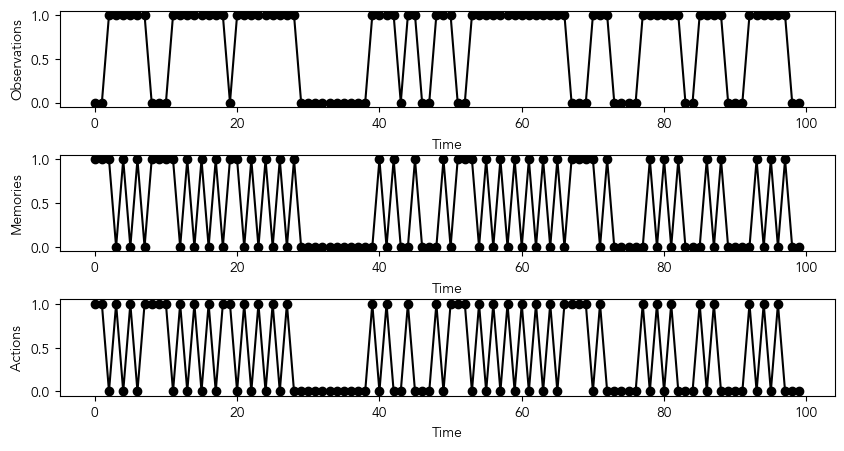

In [215]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [216]:
FSC.evaluate_nloglikelihood(trajectories[0])

0.32695466771064496

### Inference

In [217]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(67.1762, device='mps:0', grad_fn=<SubBackward0>)

In [218]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 20, NBatch = 20, lr = 0.25, gamma = 0.9)

Training with 80 trajectories and validating with 20 trajectories.
	 Epoch 1 - Batch 1 - Loss: 69.38792114257812 - Learning rate: 0.25
	 Epoch 1 - Batch 2 - Loss: 61.462286376953124 - Learning rate: 0.25
	 Epoch 1 - Batch 3 - Loss: 58.00447387695313 - Learning rate: 0.25
	 Epoch 1 - Batch 4 - Loss: 53.10718994140625 - Learning rate: 0.25
Epoch 1 - Training loss: 60.49046783447265, Validation loss: 51.646056747436525
	 Epoch 2 - Batch 1 - Loss: 49.206494140625 - Learning rate: 0.225
	 Epoch 2 - Batch 2 - Loss: 44.76578063964844 - Learning rate: 0.225
	 Epoch 2 - Batch 3 - Loss: 39.177511596679686 - Learning rate: 0.225
	 Epoch 2 - Batch 4 - Loss: 32.46528015136719 - Learning rate: 0.225
Epoch 2 - Training loss: 41.40376663208008, Validation loss: 32.41199026107788
	 Epoch 3 - Batch 1 - Loss: 27.8917724609375 - Learning rate: 0.2025
	 Epoch 3 - Batch 2 - Loss: 20.849964904785157 - Learning rate: 0.2025
	 Epoch 3 - Batch 3 - Loss: 16.086283874511718 - Learning rate: 0.2025
	 Epoch 3 - Bat

### Comparison

In [219]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


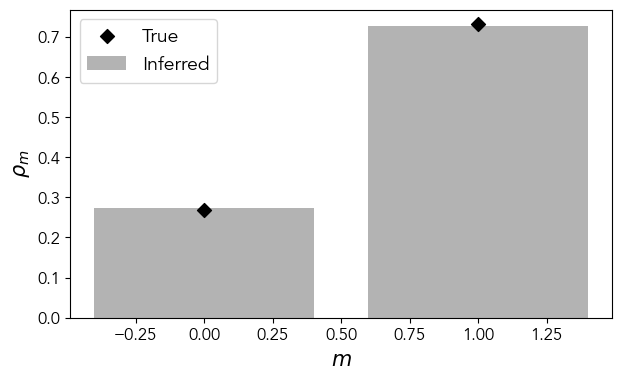

In [220]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

plt.legend(fontsize = 14)

plt.show()

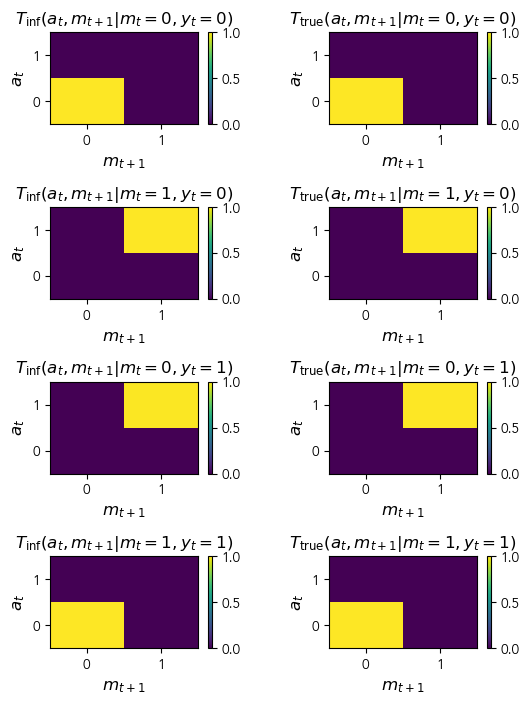

In [221]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [222]:
FSC_inferred.load_observations(observations)

In [223]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

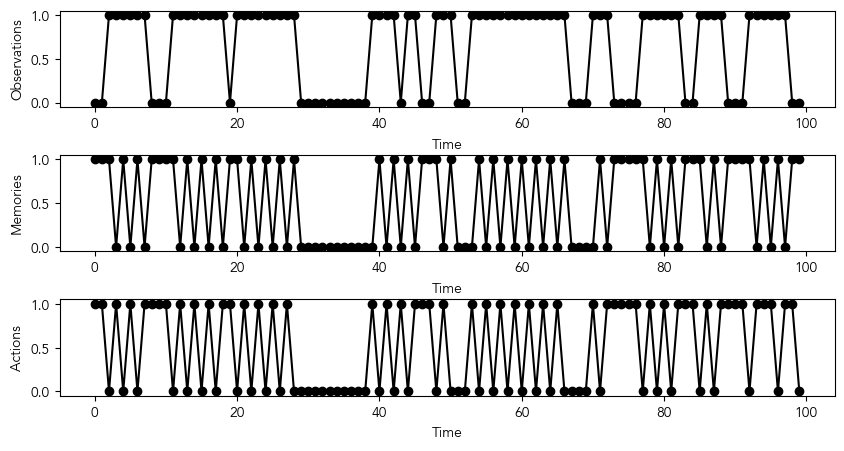

In [224]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 2$, random - working example

In [225]:
M = 2
A = 2

np.random.seed(7)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(A)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [226]:
FSC.load_observations(observations)

In [227]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

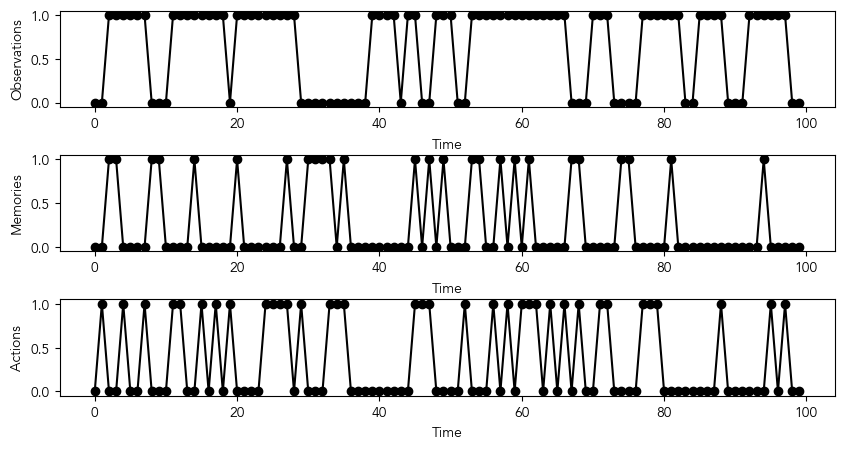

In [228]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [229]:
FSC.evaluate_nloglikelihood(trajectories[0])

64.45360479532286

### Inference

In [232]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(73.3645, device='mps:0', grad_fn=<SubBackward0>)

In [233]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 20, NBatch = 20, lr = 0.3, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 72.81714477539063 - Learning rate: 0.3
	 Epoch 1 - Batch 2 - Loss: 65.191943359375 - Learning rate: 0.3
	 Epoch 1 - Batch 3 - Loss: 67.369189453125 - Learning rate: 0.3
	 Epoch 1 - Batch 4 - Loss: 65.8858154296875 - Learning rate: 0.3
	 Epoch 1 - Batch 5 - Loss: 67.01326904296874 - Learning rate: 0.3
	 Epoch 1 - Batch 6 - Loss: 67.11481323242188 - Learning rate: 0.3
	 Epoch 1 - Batch 7 - Loss: 65.46112060546875 - Learning rate: 0.3
	 Epoch 1 - Batch 8 - Loss: 65.35523681640625 - Learning rate: 0.3
Epoch 1 - Training loss: 67.02606658935547, Validation loss: 65.72548055648804
	 Epoch 2 - Batch 1 - Loss: 64.20838623046875 - Learning rate: 0.27
	 Epoch 2 - Batch 2 - Loss: 65.81302490234376 - Learning rate: 0.27
	 Epoch 2 - Batch 3 - Loss: 64.5007080078125 - Learning rate: 0.27
	 Epoch 2 - Batch 4 - Loss: 65.87258911132812 - Learning rate: 0.27
	 Epoch 2 - Batch 5 - Loss: 65.27409057617187 - Lea

### Comparison

In [234]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


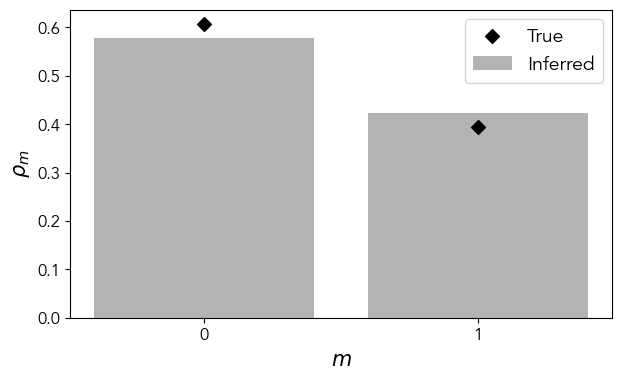

In [235]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

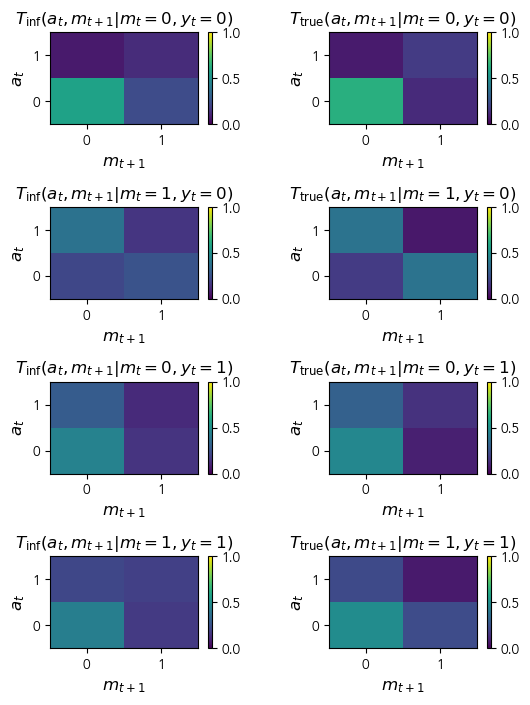

In [236]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [237]:
FSC_inferred.load_observations(observations)

In [238]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

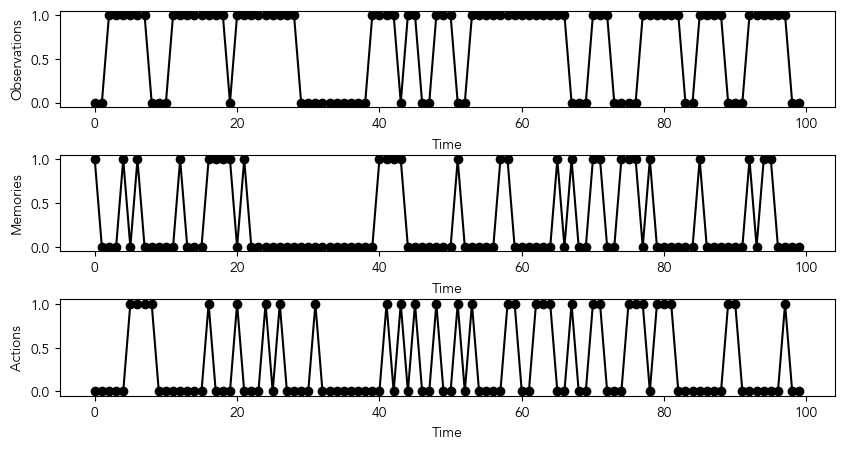

In [239]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 2$, random - harder example

In [366]:
M = 2
A = 2

np.random.seed(9)

Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(A)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [367]:
FSC.load_observations(observations)

In [368]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

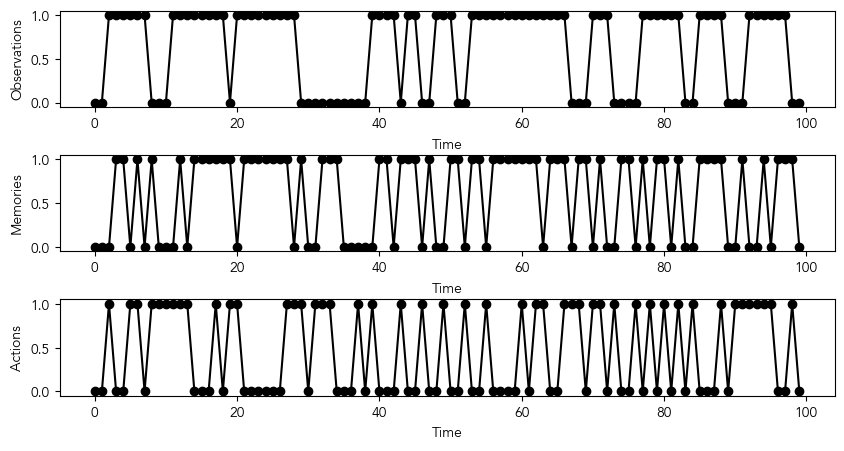

In [369]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [370]:
FSC.evaluate_nloglikelihood(trajectories[0])

67.35600929096738

### Inference

In [371]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(76.6558, device='mps:0', grad_fn=<SubBackward0>)

In [372]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 20, NBatch = 20, lr = 0.3, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 76.83209838867188 - Learning rate: 0.3
	 Epoch 1 - Batch 2 - Loss: 69.86768188476563 - Learning rate: 0.3
	 Epoch 1 - Batch 3 - Loss: 70.65296630859375 - Learning rate: 0.3
	 Epoch 1 - Batch 4 - Loss: 72.8777099609375 - Learning rate: 0.3
	 Epoch 1 - Batch 5 - Loss: 72.55531616210938 - Learning rate: 0.3
	 Epoch 1 - Batch 6 - Loss: 69.32547607421876 - Learning rate: 0.3
	 Epoch 1 - Batch 7 - Loss: 69.41327514648438 - Learning rate: 0.3
	 Epoch 1 - Batch 8 - Loss: 68.9558837890625 - Learning rate: 0.3
Epoch 1 - Training loss: 71.31005096435547, Validation loss: 68.89735851287841
	 Epoch 2 - Batch 1 - Loss: 69.11370239257812 - Learning rate: 0.27
	 Epoch 2 - Batch 2 - Loss: 69.60646362304688 - Learning rate: 0.27
	 Epoch 2 - Batch 3 - Loss: 69.94927368164062 - Learning rate: 0.27
	 Epoch 2 - Batch 4 - Loss: 69.816796875 - Learning rate: 0.27
	 Epoch 2 - Batch 5 - Loss: 69.4588623046875 - Learn

### Comparison

In [373]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = np.argsort(FSC.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


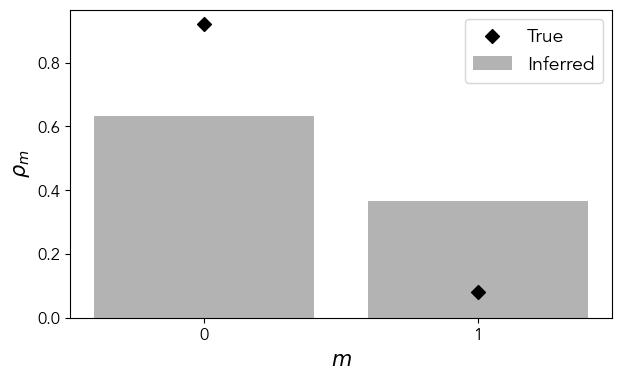

In [374]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

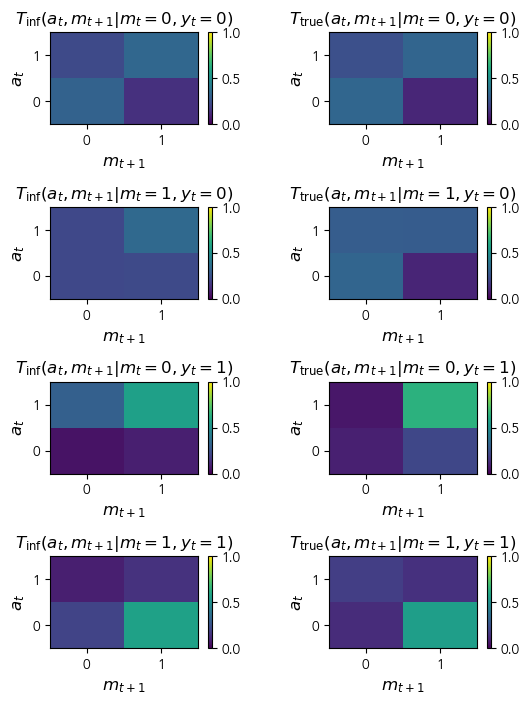

In [375]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,8))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [258]:
FSC_inferred.load_observations(observations)

In [259]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

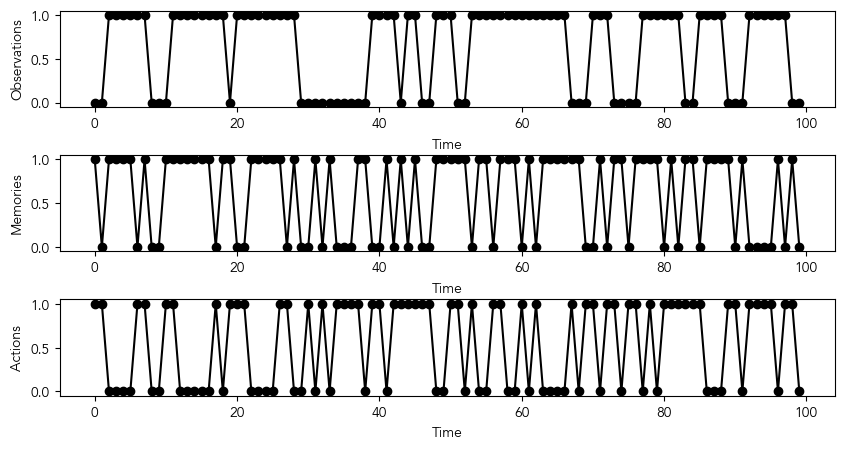

In [260]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# $M = 2$, $A = 2$, $Y = 3$ with structured transition matrix

In [356]:
NStepsObs = 300
NTraj = 500
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 5*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(500, 300)

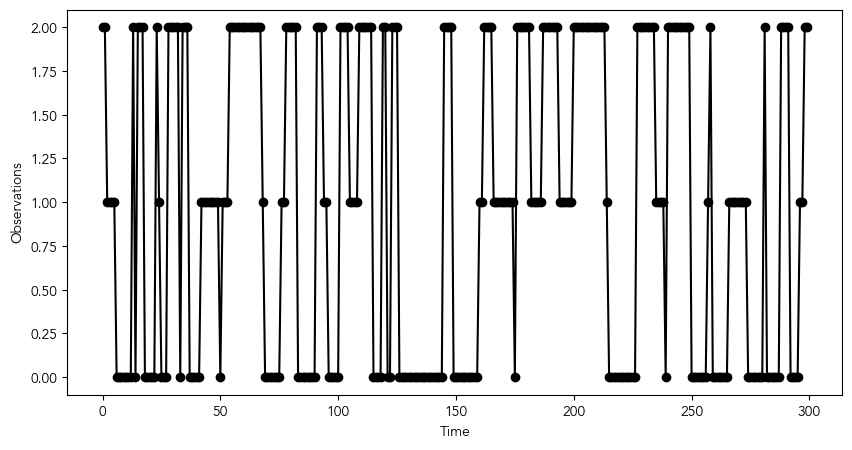

In [357]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [358]:
M = 2
A = 2

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

# when receiving a zero observation, the memory is reset to zero and action 0 is taken
ThetaFollowSwitchFollow[0] = np.array([[[10, 0.01], [0.01, 0.01]],
                                      [[10, 0.01], [0.01, 0.01]]])

# when receiving a two observation, the memory is reset to one and action 1 is taken
ThetaFollowSwitchFollow[2] = np.array([[[0.01, 0.01], [0.01, 10]],
                                      [[0.01,0.01], [0.01, 10]]])

# when receiving a one observation, the memory keeps switching between 0 and 1 and the actions is random
ThetaFollowSwitchFollow[1] = np.array([[[0.01, 0.01], [10, 10]],
                                      [[10, 10], [0.01, 0.01]]])

Psi = np.array([1, 1.5])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [337]:
FSC.load_observations(observations)

In [338]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

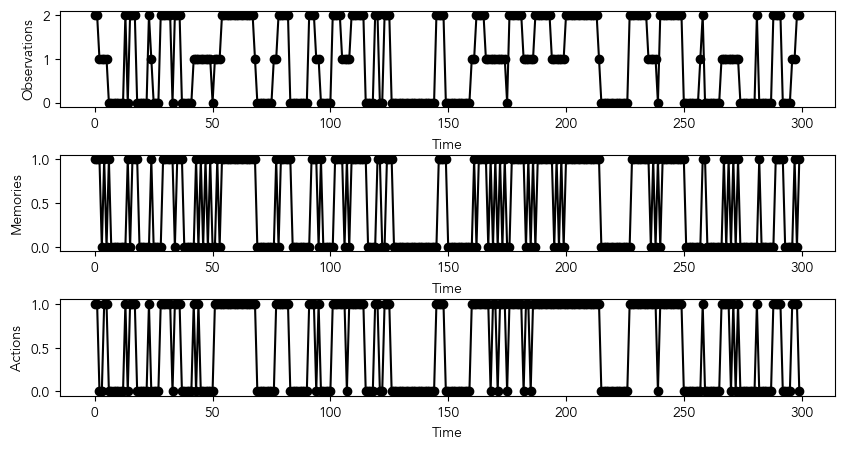

In [339]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = FSC.plot_trajectory(trj, Time)

In [340]:
FSC.evaluate_nloglikelihood(trajectories[0])

52.98690489857191

### Inference

In [350]:
M = 2
A = 2
Y = 3

In [351]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(214.2594, device='mps:0', grad_fn=<SubBackward0>)

In [352]:
tloss, vloss = FSC_tofit.optimize(NEpochs = 20, NBatch = 20, lr = 0.25, gamma = 0.9)

Training with 400 trajectories and validating with 100 trajectories.
	 Epoch 1 - Batch 1 - Loss: 223.803955078125 - Learning rate: 0.25
	 Epoch 1 - Batch 2 - Loss: 174.50628662109375 - Learning rate: 0.25
	 Epoch 1 - Batch 3 - Loss: 144.1905517578125 - Learning rate: 0.25
	 Epoch 1 - Batch 4 - Loss: 118.9798095703125 - Learning rate: 0.25
	 Epoch 1 - Batch 5 - Loss: 100.23875732421875 - Learning rate: 0.25
	 Epoch 1 - Batch 6 - Loss: 95.89892578125 - Learning rate: 0.25
	 Epoch 1 - Batch 7 - Loss: 82.09730834960938 - Learning rate: 0.25
	 Epoch 1 - Batch 8 - Loss: 87.22883911132813 - Learning rate: 0.25
	 Epoch 1 - Batch 9 - Loss: 73.96040649414063 - Learning rate: 0.25
	 Epoch 1 - Batch 10 - Loss: 78.642138671875 - Learning rate: 0.25
	 Epoch 1 - Batch 11 - Loss: 72.7756591796875 - Learning rate: 0.25
	 Epoch 1 - Batch 12 - Loss: 69.87379150390625 - Learning rate: 0.25
	 Epoch 1 - Batch 13 - Loss: 71.27474975585938 - Learning rate: 0.25
	 Epoch 1 - Batch 14 - Loss: 72.23704223632812 -

### Comparison

In [359]:
FSC_inferred = FSC_DiscreteObs(FSC_tofit.theta.detach().cpu().double().numpy(),
                               FSC_tofit.psi.detach().cpu().double().numpy(), verbose = True)

rho_sort = np.argsort(FSC.rho)

psi_sorted = FSC_inferred.psi[rho_sort]
theta_sorted = np.zeros_like(FSC_inferred.theta)

for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m1, m1 in enumerate(FSC_inferred.MemSpace):
        for idx_m2, m2 in enumerate(FSC_inferred.MemSpace):
            for idx_a, a in enumerate(FSC_inferred.ActSpace):
                theta_sorted[idx_y, idx_m1, idx_m2, idx_a] = FSC_inferred.theta[idx_y, rho_sort[idx_m1], rho_sort[idx_m2], idx_a]

FSC_inferred.load_theta(theta_sorted)
FSC_inferred.load_psi(psi_sorted)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


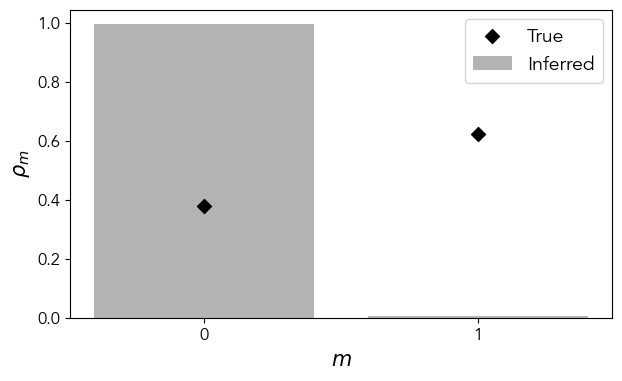

In [360]:
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.bar(np.arange(M), FSC_inferred.rho, color = "dimgray", alpha = 0.5, label = "Inferred")
ax.scatter(np.arange(M), FSC.rho, color = "black", marker = "D", s = 50, label = "True")

ax.set_xlabel("$m$", fontsize = 15)
ax.set_ylabel("$\\rho_m$", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xticks(np.arange(M))

plt.legend(fontsize = 14)

plt.show()

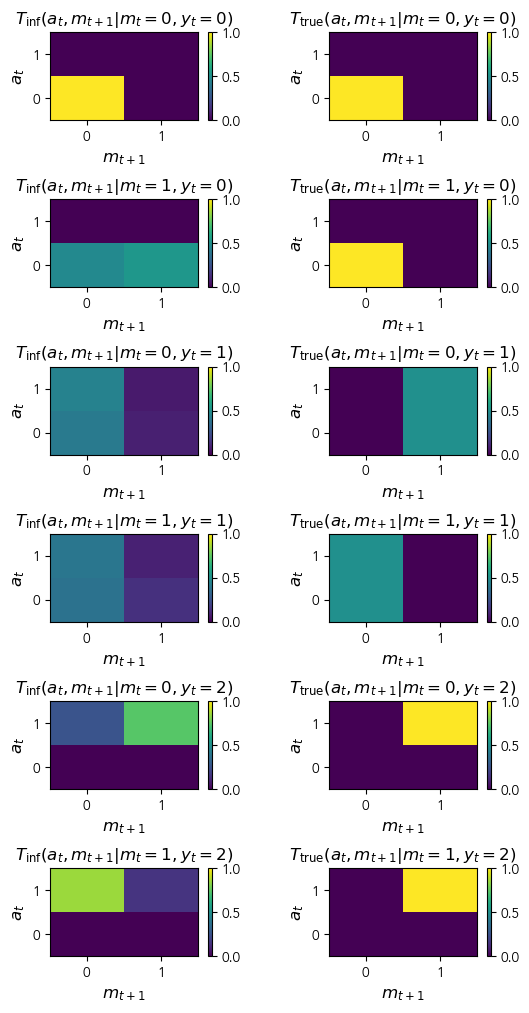

In [361]:
fig, axs = plt.subplots(Y*M, 2, figsize=(6,12))
plt.subplots_adjust(hspace = 0.9, wspace=0.5)
for a in axs.flatten():
    a.set_xticks(FSC.MemSpace)
    a.set_yticks(FSC.ActSpace)
    a.set_xlabel("$m_{t+1}$", fontsize = 12)
    a.set_ylabel("$a_t$", fontsize = 12)

c = 0
for idx_y, y in enumerate(FSC_inferred.ObsSpace):
    for idx_m, m in enumerate(FSC_inferred.MemSpace):
        im_inf = axs[c, 0].pcolormesh(FSC_inferred.MemSpace, FSC_inferred.ActSpace, FSC_inferred.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)
        im_true = axs[c, 1].pcolormesh(FSC.MemSpace, FSC.ActSpace, FSC.TMat[idx_y, idx_m].T, vmin = 0, vmax = 1)

        axs[c, 0].set_title(f"$T_\\mathrm{{inf}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")
        axs[c, 1].set_title(f"$T_\\mathrm{{true}}(a_t, m_{{t+1}} | m_t = {m}, y_{{t}} = {y})$")

        cbar_inf = fig.colorbar(im_inf, ax=axs[c, 0])
        cbar_true = fig.colorbar(im_true, ax=axs[c, 1])

        c += 1

plt.show()

In [347]:
FSC_inferred.load_observations(observations)

In [348]:
trajectories_inferred = FSC_inferred.generate_trajectories(NSteps)

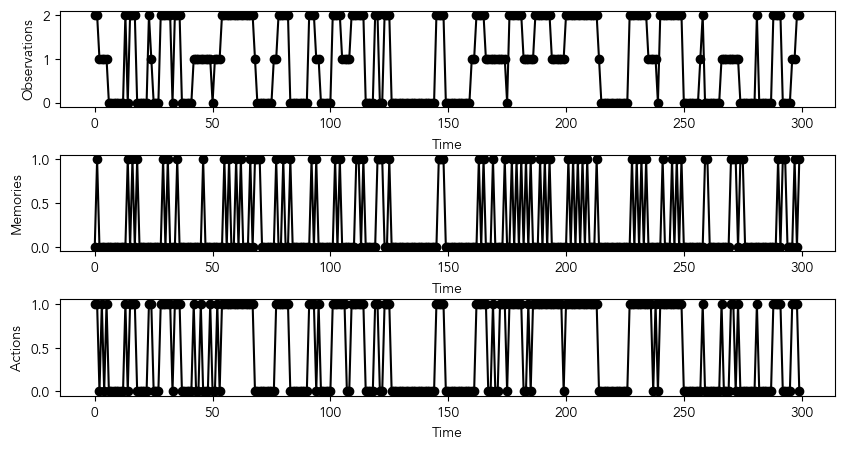

In [349]:
idx_trj = 0
trj = trajectories_inferred[idx_trj]
fig, ax = FSC_inferred.plot_trajectory(trj, Time)

# Old trials

In [367]:
NStepsObs = 100
NTraj = 200
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 2*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 0)
observations.shape

(200, 100)

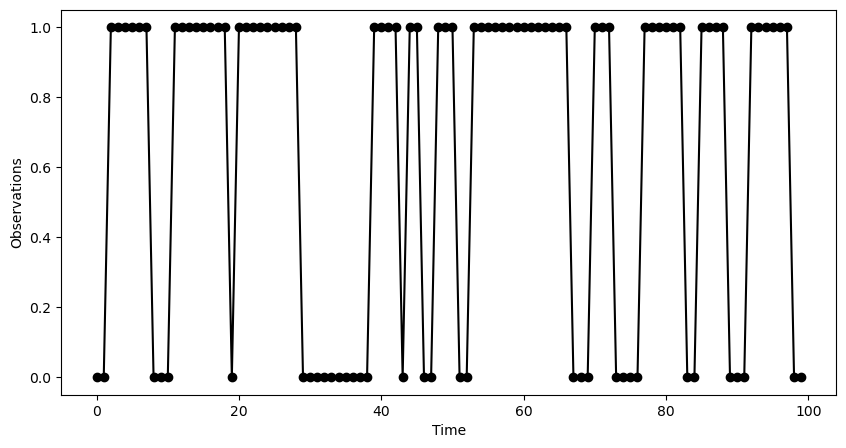

In [368]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [369]:
M = 2
A = 2
Theta = np.random.randn(Y, M, M, A)

Psi = np.random.randn(A)

FSC = FSC_DiscreteObs(Theta, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [370]:
FSC.TMat, FSC.rho

(array([[[[0.51808768, 0.13839864],
          [0.16792747, 0.17558622]],
 
         [[0.11801551, 0.01081491],
          [0.02991096, 0.84125862]]],
 
 
        [[[0.6704419 , 0.03702521],
          [0.24360295, 0.04892994]],
 
         [[0.67139756, 0.10604617],
          [0.09567751, 0.12687876]]]]),
 array([0.08528574, 0.91471426]))

In [371]:
FSC.load_observations(observations)

In [372]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

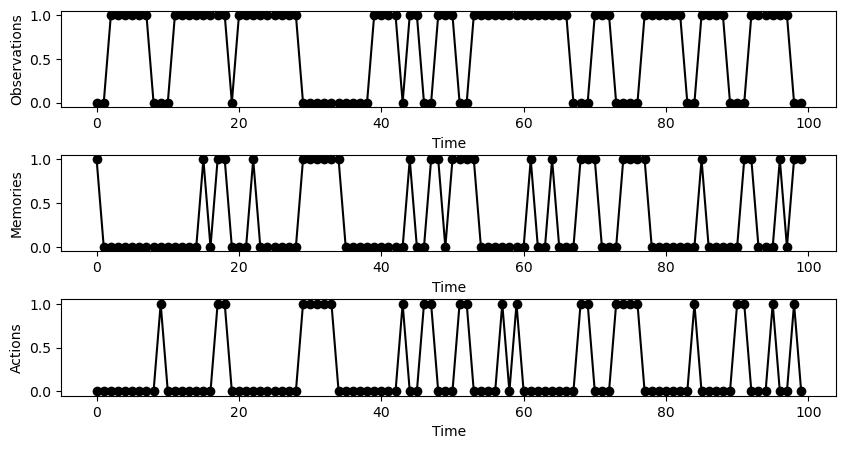

In [373]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trj["observations"], 'o', c= 'k')
ax[0].plot(Time, trj["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trj["memories"], 'o', c= 'k')
ax[1].plot(Time, trj["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time, trj["actions"], 'o', c= 'k')
ax[2].plot(Time, trj["actions"], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()

In [374]:
FSC.evaluate_nloglikelihood(trajectories[0])

42.107698064052315

In [421]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123)
FSC_tofit.load_theta(Theta.astype(np.float32))
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(41.0647, device='mps:0', grad_fn=<SubBackward0>)

In [422]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0], FSC.TMat[0][0]

(array([[0.5180877 , 0.13839863],
        [0.16792747, 0.17558621]], dtype=float32),
 array([[0.51808768, 0.13839864],
        [0.16792747, 0.17558622]]))

In [423]:
_, _ = FSC_tofit.optimize_psionly(NEpochs = 10, NBatch = 40, lr = 0.1, gamma = 0.9)

Training with 160 trajectories and validating with 40 trajectories.
	 Epoch 1 - Batch 1 - Loss: 49.867767333984375 - Learning rate: 0.1
	 Epoch 1 - Batch 2 - Loss: 50.897918701171875 - Learning rate: 0.1
	 Epoch 1 - Batch 3 - Loss: 49.77183227539062 - Learning rate: 0.1
	 Epoch 1 - Batch 4 - Loss: 51.01481628417969 - Learning rate: 0.1
Epoch 1 - Training loss: 50.38808364868164, Validation loss: 50.27743072509766
	 Epoch 2 - Batch 1 - Loss: 48.92837219238281 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 2 - Loss: 50.5696533203125 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 3 - Loss: 50.650003051757814 - Learning rate: 0.09000000000000001
	 Epoch 2 - Batch 4 - Loss: 51.08540344238281 - Learning rate: 0.09000000000000001
Epoch 2 - Training loss: 50.30835800170898, Validation loss: 50.20161848068237
	 Epoch 3 - Batch 1 - Loss: 50.636288452148435 - Learning rate: 0.08100000000000002
	 Epoch 3 - Batch 2 - Loss: 50.48311767578125 - Learning rate: 0.08100000000000002
	 Epo

In [424]:
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(42.0940, device='mps:0', grad_fn=<SubBackward0>)

In [425]:
FSC_tofit.rho.detach().cpu().numpy(), FSC.rho

(array([0.09044039, 0.9095596 ], dtype=float32),
 array([0.08528574, 0.91471426]))

In [426]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0][0], FSC.TMat[0][0][0]

(array([0.5180877 , 0.13839863], dtype=float32),
 array([0.51808768, 0.13839864]))

In [385]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0][1], FSC.TMat[0][1][0]

(array([0.16792747, 0.17558621], dtype=float32),
 array([0.11801551, 0.01081491]))

In [387]:
FSC_tofit.TMat.detach().cpu().numpy()[1], FSC.TMat[1]

(array([[[0.6704419 , 0.03702521],
         [0.24360295, 0.04892994]],
 
        [[0.67139757, 0.10604617],
         [0.0956775 , 0.12687875]]], dtype=float32),
 array([[[0.6704419 , 0.03702521],
         [0.24360295, 0.04892994]],
 
        [[0.67139756, 0.10604617],
         [0.09567751, 0.12687876]]]))

# $M = 2$, $A = 2$, $Y = 3$

In [223]:
NStepsObs = 200
NTraj = 100
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 25*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NTraj, NStepsObs, RateMatrixObs, initial_seed = 42)
observations.shape

(100, 200)

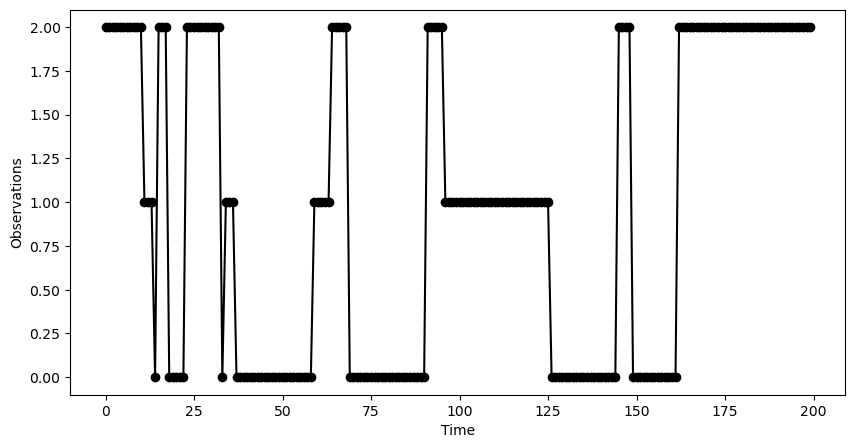

In [224]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations[0], 'o', label='Trajectory 0', color='black')
plt.plot(observations[0], color='black', label='Trajectory 0')
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [225]:
M = 2
A = 2
#Theta = np.random.randn(Y, M, M, A)

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

# when receiving a zero observation, the memory is reset to zero and action 0 is taken
ThetaFollowSwitchFollow[0] = np.array([[[10, 0.01], [0.01, 0.01]],
                                      [[10, 0.01], [0.01, 0.01]]])

# when receiving a two observation, the memory is reset to one and action 1 is taken
ThetaFollowSwitchFollow[2] = np.array([[[0.01, 0.01], [0.01, 10]],
                                      [[0.01,0.01], [0.01, 10]]])

# when receiving a one observation, the memory keeps switching between 0 and 1 and the actions is random
ThetaFollowSwitchFollow[1] = np.array([[[0.01, 0.01], [10, 10]],
                                      [[10, 10], [0.01, 0.01]]])

Psi = np.array([1, 1])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [226]:
FSC.load_observations(observations)

In [227]:
NSteps = NStepsObs
trajectories = FSC.generate_trajectories(NSteps)
Time = np.arange(NSteps)

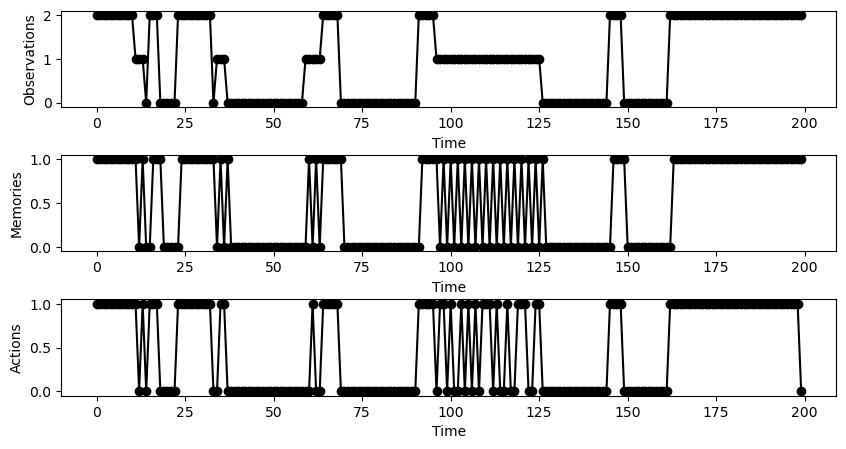

In [228]:
idx_trj = 0
trj = trajectories[idx_trj]
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trj["observations"], 'o', c= 'k')
ax[0].plot(Time, trj["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trj["memories"], 'o', c= 'k')
ax[1].plot(Time, trj["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time, trj["actions"], 'o', c= 'k')
ax[2].plot(Time, trj["actions"], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()

In [229]:
FSC.evaluate_nloglikelihood(trajectories[0])

37.730514014022624

In [240]:
FSC_tofit = FSC_InferenceDiscreteObs(M, A, Y, seed = 123456789)
FSC_tofit.load_trajectories(trajectories)
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(146.5269, device='mps:0', grad_fn=<SubBackward0>)

In [241]:
_, _ = FSC_tofit.optimize(NEpochs = 10, NBatch = 20, lr = 0.1)

Training with 80 trajectories and validating with 20 trajectories.
	 Epoch 1 - Batch 1 - Loss: 2999.701416015625
	 Epoch 1 - Batch 2 - Loss: 2687.606201171875
	 Epoch 1 - Batch 3 - Loss: 2463.2861328125
	 Epoch 1 - Batch 4 - Loss: 2195.1806640625
Epoch 1 - Training loss: 517.288720703125, Validation loss: 2249.908203125
	 Epoch 2 - Batch 1 - Loss: 2095.522705078125
	 Epoch 2 - Batch 2 - Loss: 1818.33251953125
	 Epoch 2 - Batch 3 - Loss: 1743.7674560546875
	 Epoch 2 - Batch 4 - Loss: 1533.79345703125
Epoch 2 - Training loss: 359.5708068847656, Validation loss: 1613.5625
	 Epoch 3 - Batch 1 - Loss: 1464.46923828125
	 Epoch 3 - Batch 2 - Loss: 1407.78173828125
	 Epoch 3 - Batch 3 - Loss: 1354.2564697265625
	 Epoch 3 - Batch 4 - Loss: 1225.4683837890625
Epoch 3 - Training loss: 272.5987915039062, Validation loss: 1252.34326171875
	 Epoch 4 - Batch 1 - Loss: 1225.8712158203125
	 Epoch 4 - Batch 2 - Loss: 1148.81884765625
	 Epoch 4 - Batch 3 - Loss: 1172.33349609375
	 Epoch 4 - Batch 4 - Los

In [242]:
FSC_tofit.evaluate_nloglikelihood(idx_traj = 0)

tensor(34.4864, device='mps:0', grad_fn=<SubBackward0>)

In [243]:
FSC_tofit.rho.detach().cpu().numpy(), FSC.rho

(array([0.96023947, 0.0397605 ], dtype=float32), array([0.5, 0.5]))

In [244]:
FSC_tofit.TMat.detach().cpu().numpy()[0][0], FSC.TMat[0][0]

(array([[0.9824767 , 0.00166073],
        [0.01287973, 0.00298291]], dtype=float32),
 array([[9.99862450e-01, 4.58498991e-05],
        [4.58498991e-05, 4.58498991e-05]]))

In [245]:
FSC_tofit.TMat.detach().cpu().numpy()[0][1], FSC.TMat[0][1]

(array([[0.55064726, 0.03440857],
        [0.4097581 , 0.00518605]], dtype=float32),
 array([[9.99862450e-01, 4.58498991e-05],
        [4.58498991e-05, 4.58498991e-05]]))

In [236]:
FSC_tofit.TMat.detach().cpu().numpy()[1][0], FSC.TMat[1][0]

(array([[0.32163656, 0.4434191 ],
        [0.15498103, 0.07996324]], dtype=float32),
 array([[2.29270520e-05, 2.29270520e-05],
        [4.99977073e-01, 4.99977073e-01]]))

In [237]:
FSC_tofit.TMat.detach().cpu().numpy()[1][1], FSC.TMat[1][1]

(array([[0.32497084, 0.33524534],
        [0.21613818, 0.12364567]], dtype=float32),
 array([[4.99977073e-01, 4.99977073e-01],
        [2.29270520e-05, 2.29270520e-05]]))

In [238]:
FSC_tofit.TMat.detach().cpu().numpy()[2][0], FSC.TMat[2][0]

(array([[0.00129161, 0.23214458],
        [0.00172466, 0.7648391 ]], dtype=float32),
 array([[4.58498991e-05, 4.58498991e-05],
        [4.58498991e-05, 9.99862450e-01]]))

In [239]:
FSC_tofit.TMat.detach().cpu().numpy()[2][1], FSC.TMat[2][1]

(array([[0.00220393, 0.83368194],
        [0.00128464, 0.16282952]], dtype=float32),
 array([[4.58498991e-05, 4.58498991e-05],
        [4.58498991e-05, 9.99862450e-01]]))